# Functionalized Backtester

In [30]:
import pandas as pd 
import numpy as np
from pairs import selection 

from copulas.copulae import GumbelCopula
from analysis.performance import perf_summ 

from sklearn.linear_model import RANSACRegressor, HuberRegressor
from backtest.signal_ import SignalGeneration, generate_signals

import matplotlib.pyplot as plt

from backtest.backtester import backtest
from backtest.positions import calc_rolling_betas

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing Price Data

In [3]:
WINDOW_SIZE = 252
MOD_REGRESSION = 3 
TRANSACTION_COST = 0.0002

In [4]:
import v2.backtest.signal_ as sig
import v2.backtest.backtester as bt
import v2.backtest.hedging as hedging

prices = pd.read_csv('raw_futures_prices.csv', index_col=0, parse_dates=[0])

raw_prices = prices.copy()

start = '2018-01-01'
end = '2020-01-01'
trading_end = '2021-01-01'

pairs = [('TU', 'UXY'), ('TU', 'FV'), ('UXY', 'WN')]

signal_object = sig.SignalGeneration(prices, pairs, start, end, trading_end, copula_type = ['gumbel', 'clayton'], n= 10)
sig1 = signal_object.calc_signals()

# This produces the probabilities for each pair.
sig1.round(4)

TU             UXY
        UXY      FV      WN
0    0.8764  0.5378  0.8751
1    0.1698  0.2842  0.8837
2    0.1790  0.3597  0.9671
3    0.4958  0.4685  0.9853
4    0.6939  0.5329  0.9675
..      ...     ...     ...
246  0.9929  0.7154  0.6717
247  0.8555  0.5388  0.3953
248  0.8808  0.5821  0.5094
249  0.6099  0.4799  0.3848
250  0.4611  0.4299  0.2409

[251 rows x 3 columns]

In [5]:
# We can look at the copulas too
cop_1 = signal_object.copulae[pairs[0]]
print(f'Pair 1: {pairs[0]}')
print(f'Copula 1: {cop_1.copula1.__class__.__name__}')
print(f'Copula 2: {cop_1.copula2.__class__.__name__}')
print(f'Alpha (mixing parameter): {cop_1.alpha}')
print('~'*50)
cop_2 = signal_object.copulae[pairs[1]]
print(f'Pair 2: {pairs[1]}')
print(f'Copula 1: {cop_2.copula1.__class__.__name__}')
print(f'Copula 2: {cop_2.copula2.__class__.__name__}')
print(f'Alpha (mixing parameter): {cop_2.alpha}')
print('~'*50)
cop_3 = signal_object.copulae[pairs[2]]
print(f'Pair 3: {pairs[2]}')
print(f'Copula 1: {cop_3.copula1.__class__.__name__}')
print(f'Copula 2: {cop_3.copula2.__class__.__name__}')
print(f'Alpha (mixing parameter): {cop_3.alpha}')

Pair 1: ('TU', 'UXY')
Copula 1: GumbelCopula
Copula 2: ClaytonCopula
Alpha (mixing parameter): 0.6607505765815774
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Pair 2: ('TU', 'FV')
Copula 1: GumbelCopula
Copula 2: ClaytonCopula
Alpha (mixing parameter): 0.8732387272446988
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Pair 3: ('UXY', 'WN')
Copula 1: GumbelCopula
Copula 2: ClaytonCopula
Alpha (mixing parameter): 0.9442719099991588


In [6]:
def calc_contract_margin(ticker):
    if ticker == 'TU':
        return 1400, 2000
    elif ticker == 'UXY':
        return 3100, 1000
    elif ticker == 'FV':
        return 1700, 1000
    elif ticker == 'US':
        return 2000, 1000
    elif ticker == 'WN':
        return 6500, 1000
    else:
        return 1, 1

res = []

for pair in pairs:
    oos_data = prices[[pair[0],pair[1]]].loc[end:trading_end]
    oos_data['Signal'] = signal_object.generate_signals(sig1 = sig1[pair]).values
    is_beta = hedging.beta_calc(prices[pair[0]].loc[start:end], prices[pair[1]].loc[start:end], mod=3)
    oos_data['Betas'] = round(is_beta, 2)

    # Set the margins and contract size manually
    margin_1, contract_1 = calc_contract_margin(pair[0])
    margin_2, contract_2 = calc_contract_margin(pair[1])
    margins = [margin_1, margin_2]
    contract_mult = [contract_1, contract_2]

    # Run the backtest
    res.append(bt.backtest(oos_data, initial_capital=500_000, contract_mult=contract_mult, margins=margins, TRANSACTION_COST=0.0000, risk_mult=10))
    display(res[-1])

,TU,UXY,Signal,Betas,Transaction Cost,Daily PnL,Pos 1,Pos 2,Position Value,Total PnL,Total Transaction
date,,,,,,,,,,,
2020-01-02,107.3086,134.531250,-1,0.87,0,0.0,-36.0,13.92,-5853544.2,0.0,0
2020-01-03,107.4141,135.687500,1,0.87,0,8499.0,0.0,0.00,0.0,8499.0,0
2020-01-06,107.3828,135.453125,0,0.87,0,0.0,0.0,0.00,0.0,8499.0,0
2020-01-07,107.3789,135.265625,0,0.87,0,0.0,0.0,0.00,0.0,8499.0,0
2020-01-08,107.3047,134.687500,0,0.87,0,0.0,0.0,0.00,0.0,8499.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,109.6562,147.781250,0,0.87,0,-19826.1,-108.0,41.76,-17514394.2,266960.1,0
2020-12-28,109.6523,148.125000,0,0.87,0,15197.4,-108.0,41.76,-17499196.8,282157.5,0
2020-12-29,109.6602,148.109375,0,0.87,0,-2358.9,-108.0,41.76,-17501555.7,279798.6,0


,TU,FV,Signal,Betas,Transaction Cost,Daily PnL,Pos 1,Pos 2,Position Value,Total PnL,Total Transaction
date,,,,,,,,,,,
2020-01-02,107.3086,117.492188,0,0.94,0,0.0,0.0,0.0,0.0,0.0000,0
2020-01-03,107.4141,117.875000,0,0.94,0,0.0,0.0,0.0,0.0,0.0000,0
2020-01-06,107.3828,117.781250,0,0.94,0,0.0,0.0,0.0,0.0,0.0000,0
2020-01-07,107.3789,117.750000,0,0.94,0,0.0,0.0,0.0,0.0,0.0000,0
2020-01-08,107.3047,117.515625,0,0.94,0,0.0,0.0,0.0,0.0,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,109.6562,124.109375,0,0.94,0,0.0,0.0,0.0,0.0,26618.9232,0
2020-12-28,109.6523,124.164062,0,0.94,0,0.0,0.0,0.0,0.0,26618.9232,0
2020-12-29,109.6602,124.171875,0,0.94,0,0.0,0.0,0.0,0.0,26618.9232,0


,UXY,WN,Signal,Betas,Transaction Cost,Daily PnL,Pos 1,Pos 2,Position Value,Total PnL,Total Transaction
date,,,,,,,,,,,
2020-01-02,134.531250,180.25000,-1,0.78,0,0.0,-16.0,6.24,-1027740.0,0.0,0
2020-01-03,135.687500,183.15625,0,0.78,0,-365.0,-16.0,6.24,-1028105.0,-365.0,0
2020-01-06,135.453125,182.06250,0,0.78,0,-3075.0,-16.0,6.24,-1031180.0,-3440.0,0
2020-01-07,135.265625,181.25000,0,0.78,0,-2070.0,-16.0,6.24,-1033250.0,-5510.0,0
2020-01-08,134.687500,179.46875,0,0.78,0,-1865.0,-16.0,6.24,-1035115.0,-7375.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,147.781250,207.75000,0,0.78,0,0.0,0.0,0.00,0.0,371140.0,0
2020-12-28,148.125000,209.09375,0,0.78,0,0.0,0.0,0.00,0.0,371140.0,0
2020-12-29,148.109375,208.84375,0,0.78,0,0.0,0.0,0.00,0.0,371140.0,0


In [7]:
# Agg the "total_pnl" in a dataframe, and add $1m initial capital.

df = pd.concat([x['Total PnL'] for x in res], axis=1)
df.columns = pairs
df = df + 1_000_000
rets = df.pct_change().dropna()

from analysis.performance import multi_perf_summ

multi_perf_summ(rets, adj=252).T

,"(TU, UXY)","(TU, FV)","(UXY, WN)"
Annualized Return,0.31117,0.030667,0.339018
Annualized Volatility,0.340699,0.092486,0.207589
Annualized Sharpe Ratio,0.913326,0.33159,1.633124
Annualized Sortino Ratio,0.841348,0.187631,2.005616
Skewness,0.543427,4.785908,4.71973
Excess Kurtosis,20.463021,61.303503,53.391306
VaR (0.05),-0.022137,-0.000371,-0.008768
CVaR (0.05),-0.050201,-0.010064,-0.020224
Min,-0.138046,-0.031099,-0.071473
Max,0.14357,0.059836,0.135929


Compare copula and linear method for a pair

In [8]:
def calc_quantiles(spread):
    # Comparison for linear model.
    up_1 = spread.quantile(.95).item()
    up_2 = spread.quantile(.9).item()
    up_3 = spread.quantile(.85).item()
    lo_1 = spread.quantile(0.05).item()
    lo_2 = spread.quantile(0.10).item()
    lo_3 = spread.quantile(0.15).item()
    exit_up = spread.quantile(0.80).item()
    exit_lo = spread.quantile(0.2).item()
    return [up_1,up_2,up_3,lo_1,lo_2,lo_3,exit_up,exit_lo]

In [25]:
def simulate(pair, prices, signal_probabilities, FIT_START, FIT_END, TEST_END, mod=MOD_REGRESSION, contracts=100, TRANSACTION_COST=0.0):
    # Copula Signals
    copula_signals = generate_signals(signal_probabilities[pair])
    price_list = prices[[pair[0],pair[1]]]
    
    # Get betas
    betas = calc_rolling_betas(prices[pair[0]],prices[pair[1]],mod=mod, WINDOW_SIZE=WINDOW_SIZE)
    copula_prices = pd.concat([price_list,copula_signals,betas],axis=1)
    copula_prices = copula_prices.dropna()

    # Linear model
    rets = prices[[pair[0],pair[1]]].pct_change().dropna()
    spread = (rets[pair[0]] - rets[pair[1]]).to_frame('Spread')
    train_spread = spread.loc[FIT_START:FIT_END]
    test_spread = spread.loc[FIT_END:TEST_END]
    q = calc_quantiles(train_spread)
    linear_signals = generate_signals(test_spread,q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7])
    linear_prices = pd.concat([price_list,linear_signals,betas],axis=1)
    linear_prices = linear_prices.dropna()

    # Backtest
    copula_backtest = backtest(copula_prices,contract_size=contracts, TRANSACTION_COST=TRANSACTION_COST)
    linear_backtest = backtest(linear_prices,contract_size=contracts, TRANSACTION_COST=TRANSACTION_COST)

    copula_tot_pnl = copula_backtest['Total PnL']
    linear_tot_pnl = linear_backtest['Total PnL']

    tot_pnl = pd.concat([copula_tot_pnl,linear_tot_pnl],axis=1)
    tot_pnl.columns = ['Copula','Linear']

    return tot_pnl, copula_backtest, linear_backtest

In [26]:
def analyze(pnls, prices, capital=10000):
    portfolio = pnls + capital 
    rets = portfolio.pct_change().dropna()

    metrics = perf_summ(rets,adj=252,mkt=None).T #prices.pct_change().dropna().loc[rets.index,'SPY']).T
    metrics = metrics.loc[['Annualized Return',
                        'Annualized Volatility',
                        'Annualized Sharpe Ratio',
                        'Annualized Sortino Ratio',
                        # 'Market Beta',
                        # 'Market Alpha',
                        'Max Drawdown']]
    
    return metrics 

In [49]:
def main(y, n, pair_list = None):
    global FIT_START, FIT_END, TEST_START, TEST_END, WINDOW_SIZE, MOD_REGRESSION
    global prices, signal_probabilities
    
    FIT_START = str(y)
    FIT_END = str(y+2)

    TEST_START = FIT_END 
    TEST_END = str(y+3)

    WINDOW_SIZE = 252 

    
    idx_start = raw_prices.index.get_loc(raw_prices.loc[FIT_START:].index[0])
    prices = raw_prices.iloc[idx_start-WINDOW_SIZE:]
    prices = prices.dropna(axis=0)
    prices = prices.loc[:TEST_END]

    training_data = prices.loc[FIT_START:FIT_END]
    test_data = prices.loc[TEST_START:TEST_END]

    if not pair_list:
        pairs = selection.PairSelection(prices.loc[FIT_START:FIT_END])
        pairs.create_clusters()
        pairs.test_coint()
        pair_list = pairs.get_pairs(number_of_pairs=5)

    sig_gen = sig.SignalGeneration(prices,pairs=pair_list,train_start=FIT_START,oos_start=TEST_START,n=n)
    signal_probabilities = sig_gen.calc_signals()
    signal_probabilities.index = prices[TEST_START:TEST_END].index


    pair_idx = pd.MultiIndex.from_product([pair_list, ['Copula','Linear']])
    res = pd.DataFrame(columns=pair_idx,index=['Annualized Return',
                            'Annualized Volatility',
                            'Annualized Sharpe Ratio',
                            'Annualized Sortino Ratio',
                            # 'Market Beta',
                            # 'Market Alpha',
                            'Max Drawdown'])
        
    copula_pnls = pd.DataFrame(columns=pair_list)
    linear_pnls = pd.DataFrame(columns=pair_list)
    for pair in pair_list:
        pnls, _, _ = simulate(pair, prices, signal_probabilities, FIT_START=FIT_START, FIT_END=FIT_END, TEST_END=TEST_END, contracts=20, TRANSACTION_COST=TRANSACTION_COST)
        copula_pnls[pair] = pnls['Copula']
        linear_pnls[pair] = pnls['Linear']

    copula_pnls['Total PnL'] = copula_pnls.sum(axis=1)
    linear_pnls['Total PnL'] = linear_pnls.sum(axis=1)

    port_pnl = pd.concat([copula_pnls['Total PnL'],linear_pnls['Total PnL']],axis=1)
    port_pnl.columns = ['Copula Weighted','Linear Weighted']

    performance = analyze(port_pnl, prices)
    return performance.iloc[:,0], performance.iloc[:,1]

from tqdm import tqdm

cop_res10 = []
cop_res30 = []
linear_res = []
pair_list = [('TU', 'UXY'), ('TU', 'FV'), ('UXY', 'WN')]
TRANSACTION_COST = 0.0
for y in tqdm(range(2019, 2021), desc = 'Year'):
    i, j = main(y, n = 10, pair_list = pair_list)
    k, _ = main(y, n = 30, pair_list = pair_list)
    cop_res10.append(i.rename(y+2, inplace = True))
    cop_res30.append(k.rename(y+2, inplace = True))
    linear_res.append(j.rename(y+2, inplace = True))

    c10 = pd.concat(cop_res10, axis=1).T
    c30 = pd.concat(cop_res30, axis=1).T
    l_res = pd.concat(linear_res, axis=1).T

Year: 100%|██████████| 2/2 [02:26<00:00, 73.35s/it]


In [50]:
c10 = pd.concat(cop_res10, axis=1).T
c30 = pd.concat(cop_res30, axis=1).T
l_res = pd.concat(linear_res, axis=1).T

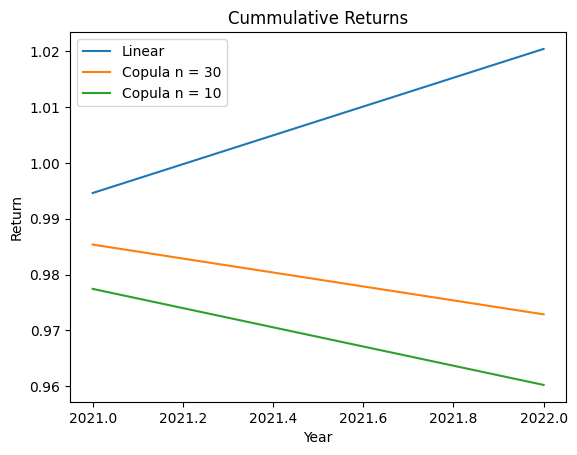

In [51]:
(l_res.iloc[:, 0] +1).cumprod().plot(title='Cummulative Returns', xlabel = 'Year', ylabel = 'Return')
(c30.iloc[:, 0] +1).cumprod().plot()
(c10.iloc[:, 0] +1).cumprod().plot()
plt.legend(['Linear', 'Copula n = 30', "Copula n = 10"])
plt.show()

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Max Drawdown
2021,-0.022579,0.023095,-0.977644,-1.123131,-0.070213
2022,-0.017622,0.016774,-1.050557,-1.344502,-0.033314


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Max Drawdown
2021,-0.005381,0.013964,-0.385346,-0.419369,-0.030724
2022,0.025981,0.021969,1.182579,1.420669,-0.024631


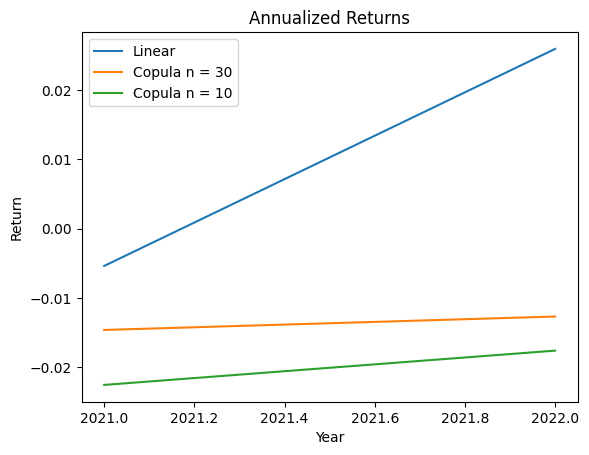

In [52]:
l_res.iloc[:, 0].plot(title='Annualized Returns', xlabel = 'Year', ylabel = 'Return')
c30.iloc[:, 0].plot()
c10.iloc[:, 0].plot()
plt.legend(['Linear', 'Copula n = 30', "Copula n = 10"])
display(c10)
display(l_res)

Text(0, 0.5, 'Returns')

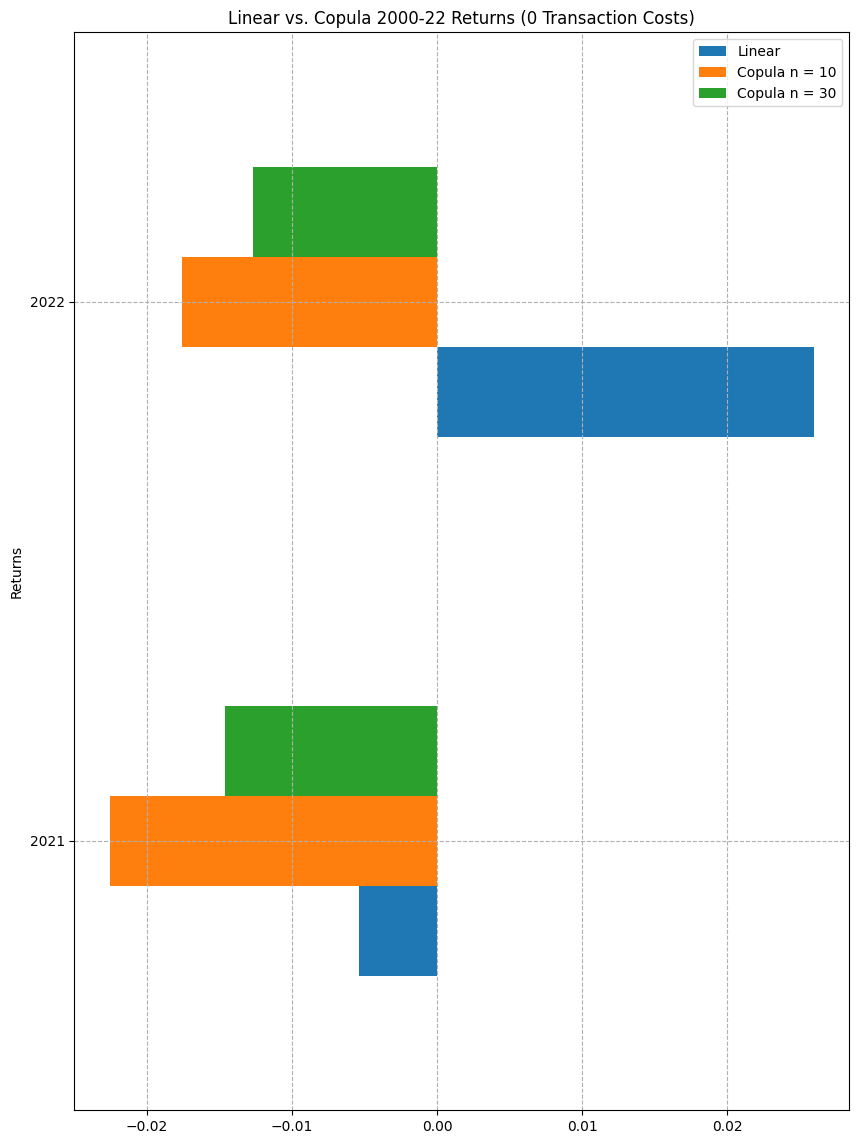

In [55]:
rets = pd.DataFrame({'Linear': l_res.iloc[:, 0], 'Copula n = 10': c10.iloc[:, 0], 'Copula n = 30': c30.iloc[:, 0]})

fig, ax = plt.subplots(figsize=(10,14))
rets.plot(kind='barh', ax=ax)
ax.set_title(f'Linear vs. Copula 2021-22 Returns (0 Transaction Costs)')
ax.grid(linestyle='--')
ax.set_ylabel('Returns')

## Sample Demo

In [ ]:
# Given a DataFrame indexed by time, with asset prices as columns,
# split into training/testing sets.
FIT_START = '2020-01-01'
FIT_END = '2021-12-31'
TEST_START = '2022-01-01'
TEST_END = '2022-12-31'
TRANSACTION_COST = 0.0002

# Select the pairs from the data.
from pairs.selection import PairSelection

pairs = PairSelection(raw_prices.loc[FIT_START:FIT_END])

# Create the clusters via OPTICS
pairs.create_clusters()

# Test cointegration; get pairs that are most cointegrated in-sample.
pairs.test_coint()
pair_list = pairs.get_pairs(number_of_pairs=5)
display(pair_list)

In [ ]:
# Next, we fit the copula, using n=30 as a smoothing parameter,
# this automatically calculates the mixed copula parameters.
sig_gen = SignalGeneration(prices,pairs=pair_list,train_start=FIT_START,oos_start=TEST_START,n=30)

# Turn the probabilities into signals for OOS data.
signal_probabilities = sig_gen.calc_signals()
signal_probabilities.index = prices[TEST_START:TEST_END].index


# Results DataFrame.
res = pd.DataFrame(columns=['Copula'],index=['Annualized Return',
                        'Annualized Volatility',
                        'Annualized Sharpe Ratio',
                        'Annualized Sortino Ratio',
                        'Market Beta',
                        'Market Alpha',
                        'Max Drawdown'])
        
copula_pnls = pd.DataFrame(columns=pair_list)

for pair in pair_list:
    # Simulate the strategy.    
    pnls, _, _ = simulate(pair, prices, signal_probabilities, FIT_START=FIT_START, FIT_END=FIT_END, TEST_END=TEST_END, contracts=20, TRANSACTION_COST=TRANSACTION_COST)
    copula_pnls[pair] = pnls['Copula']

    copula_pnls['Total PnL'] = copula_pnls.sum(axis=1)

    port_pnl = pd.DataFrame(copula_pnls['Total PnL'])
    port_pnl.columns = ['Copula Weighted']

    # Analyze the performance.
    performance = analyze(port_pnl, prices)

In [ ]:
performance